In [1]:
# importing libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# importing data
df = pd.read_csv('../2.Downloading data/processed_high_impact_outages.csv', parse_dates=['Start', 'Finish'])
df = df.replace({r"\r|\n": " "}, regex=True)
df.columns = df.columns.str.replace(r'[\r\n]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
df = df.drop(columns=['Status_Description_Market', 'Market_Notice_Code', 'Impact_Region'])

# remove unplanned
df = df[df['Unplanned?'] != 1]

# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]
df.head(5)

,Region,NSP,Start,Finish,Network Asset,Recall_Day_Hours,Recall_Night_Hours,Project Work?,Unplanned?,DNSP Aware?,Generator Aware?,Inter-Regional,Status_Description,Status_Code,Reason,Duration_Hours,Impact,file_name
0,NSW,Transgrid,2021-08-30 06:05:00,2021-09-01 12:00:00,Armidale - Dumaresq (8C) 330 kV Line,3.0,4.0,0,0,0,0,1,In Progress,PTP,Commissioning,52.8,<<UPDATED since the last notification>> A cre...,2021-08-30
1,QLD,Powerlink,2021-09-01 08:30:00,2021-09-01 12:00:00,Ross No.4 288/138/19 kV Transformer,1.0,0.0,0,0,1,0,0,Planned,MTLTP,Maintenance,3.5,This is a high impact outage because the recal...,2021-08-30
2,NSW,Transgrid,2021-09-04 06:00:00,2021-09-05 17:00:00,Liddell to Muswellbrook (83) 330 kV Line,4.0,4.0,0,0,1,0,1,Planned,MTLTP,Commissioning,36.0,A credible contingency event during this plann...,2021-08-30
3,SA,ElectraNet,2021-09-06 08:00:00,2021-09-12 08:15:00,Heywood - South East No.1 275 kV Line,159.0,159.0,0,0,0,0,1,Planned,SUBMIT,Commissioning,144.0,<<NEW since the last notification>> A credibl...,2021-08-30
4,QLD,Powerlink,2021-09-06 08:30:00,2021-09-10 16:00:00,Ross No.3 288/138/19 kV Transformer,4.0,6.0,0,0,1,0,0,Planned,MTLTP,Maintenance,103.2,This is a high impact outage because the recal...,2021-08-30


In [3]:
df['Region'].value_counts()

Region
VIC    10094
QLD     3512
SA      2533
NSW     1122
TAS     1016
Name: count, dtype: int64

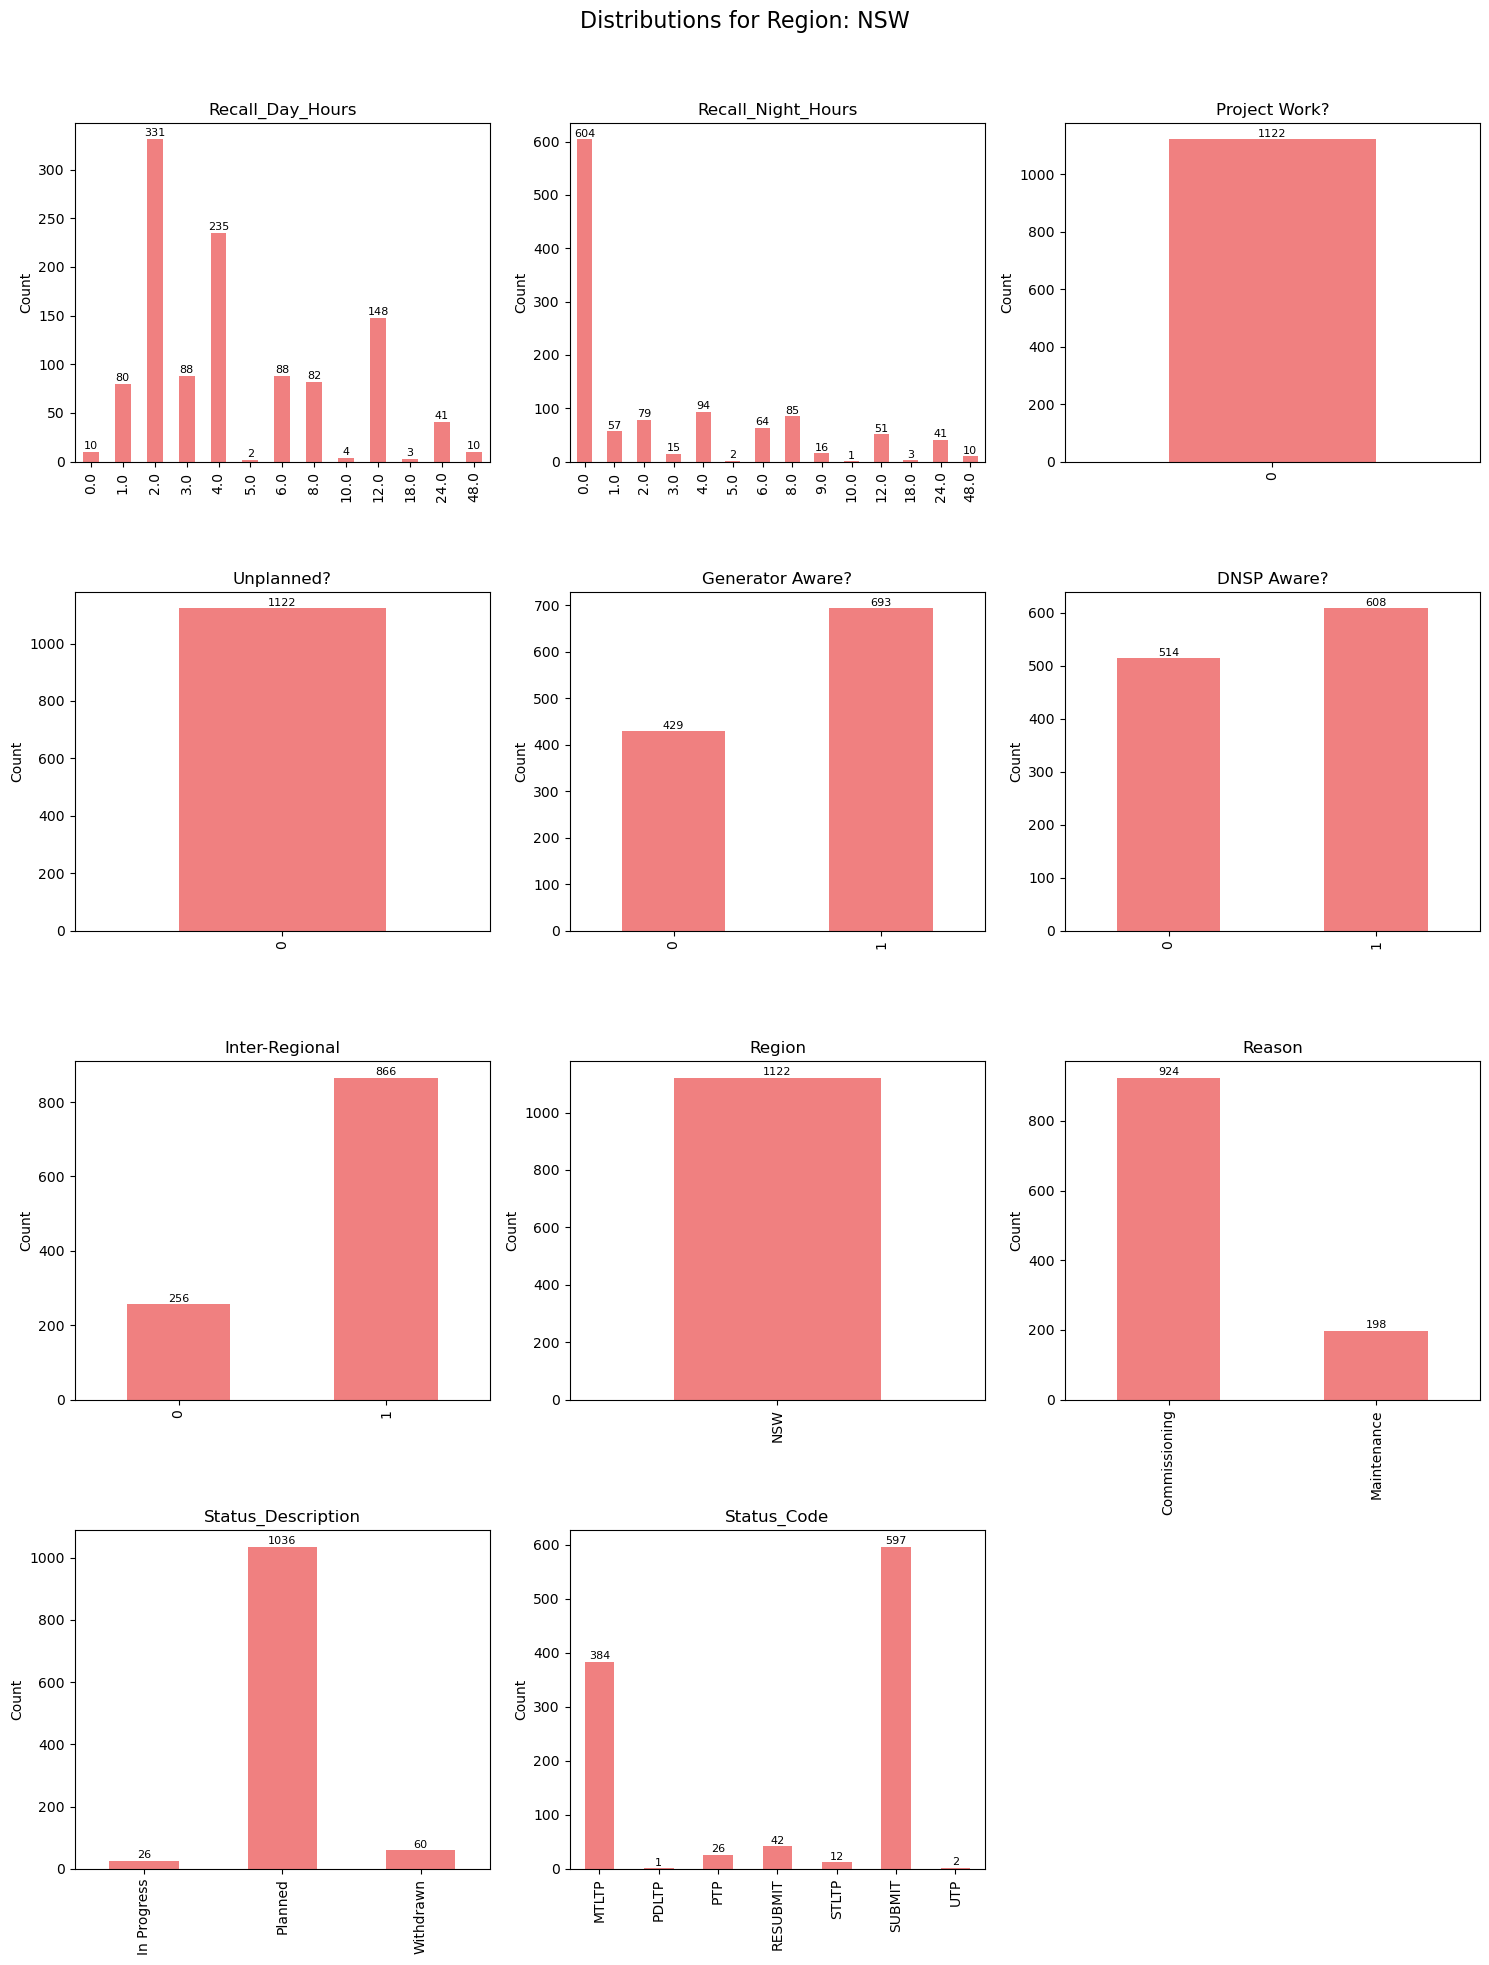

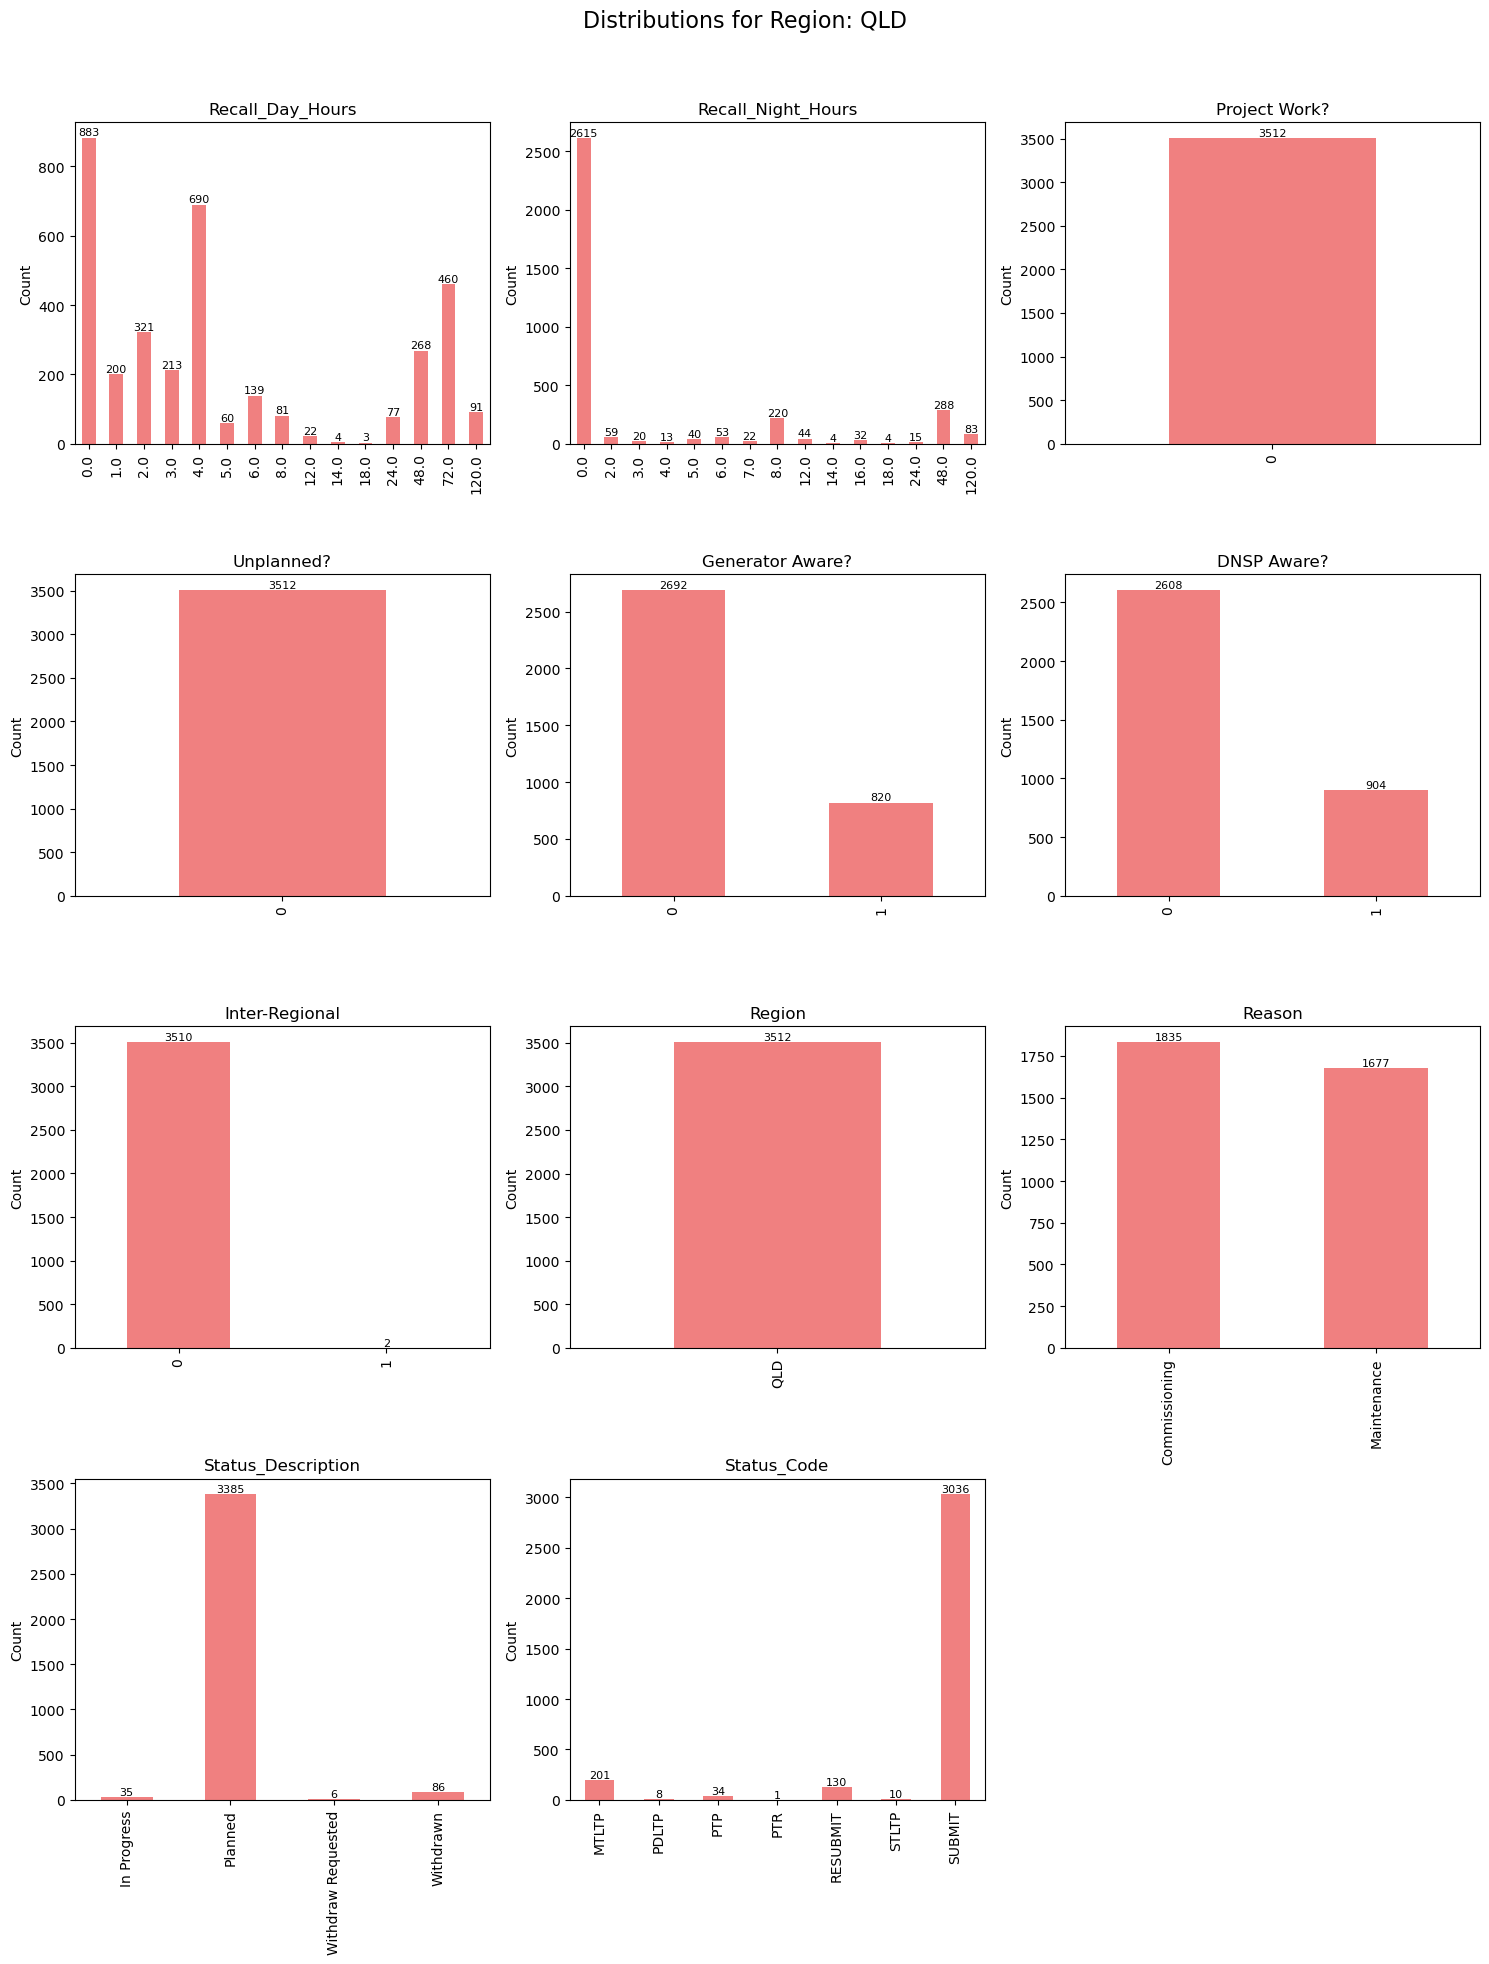

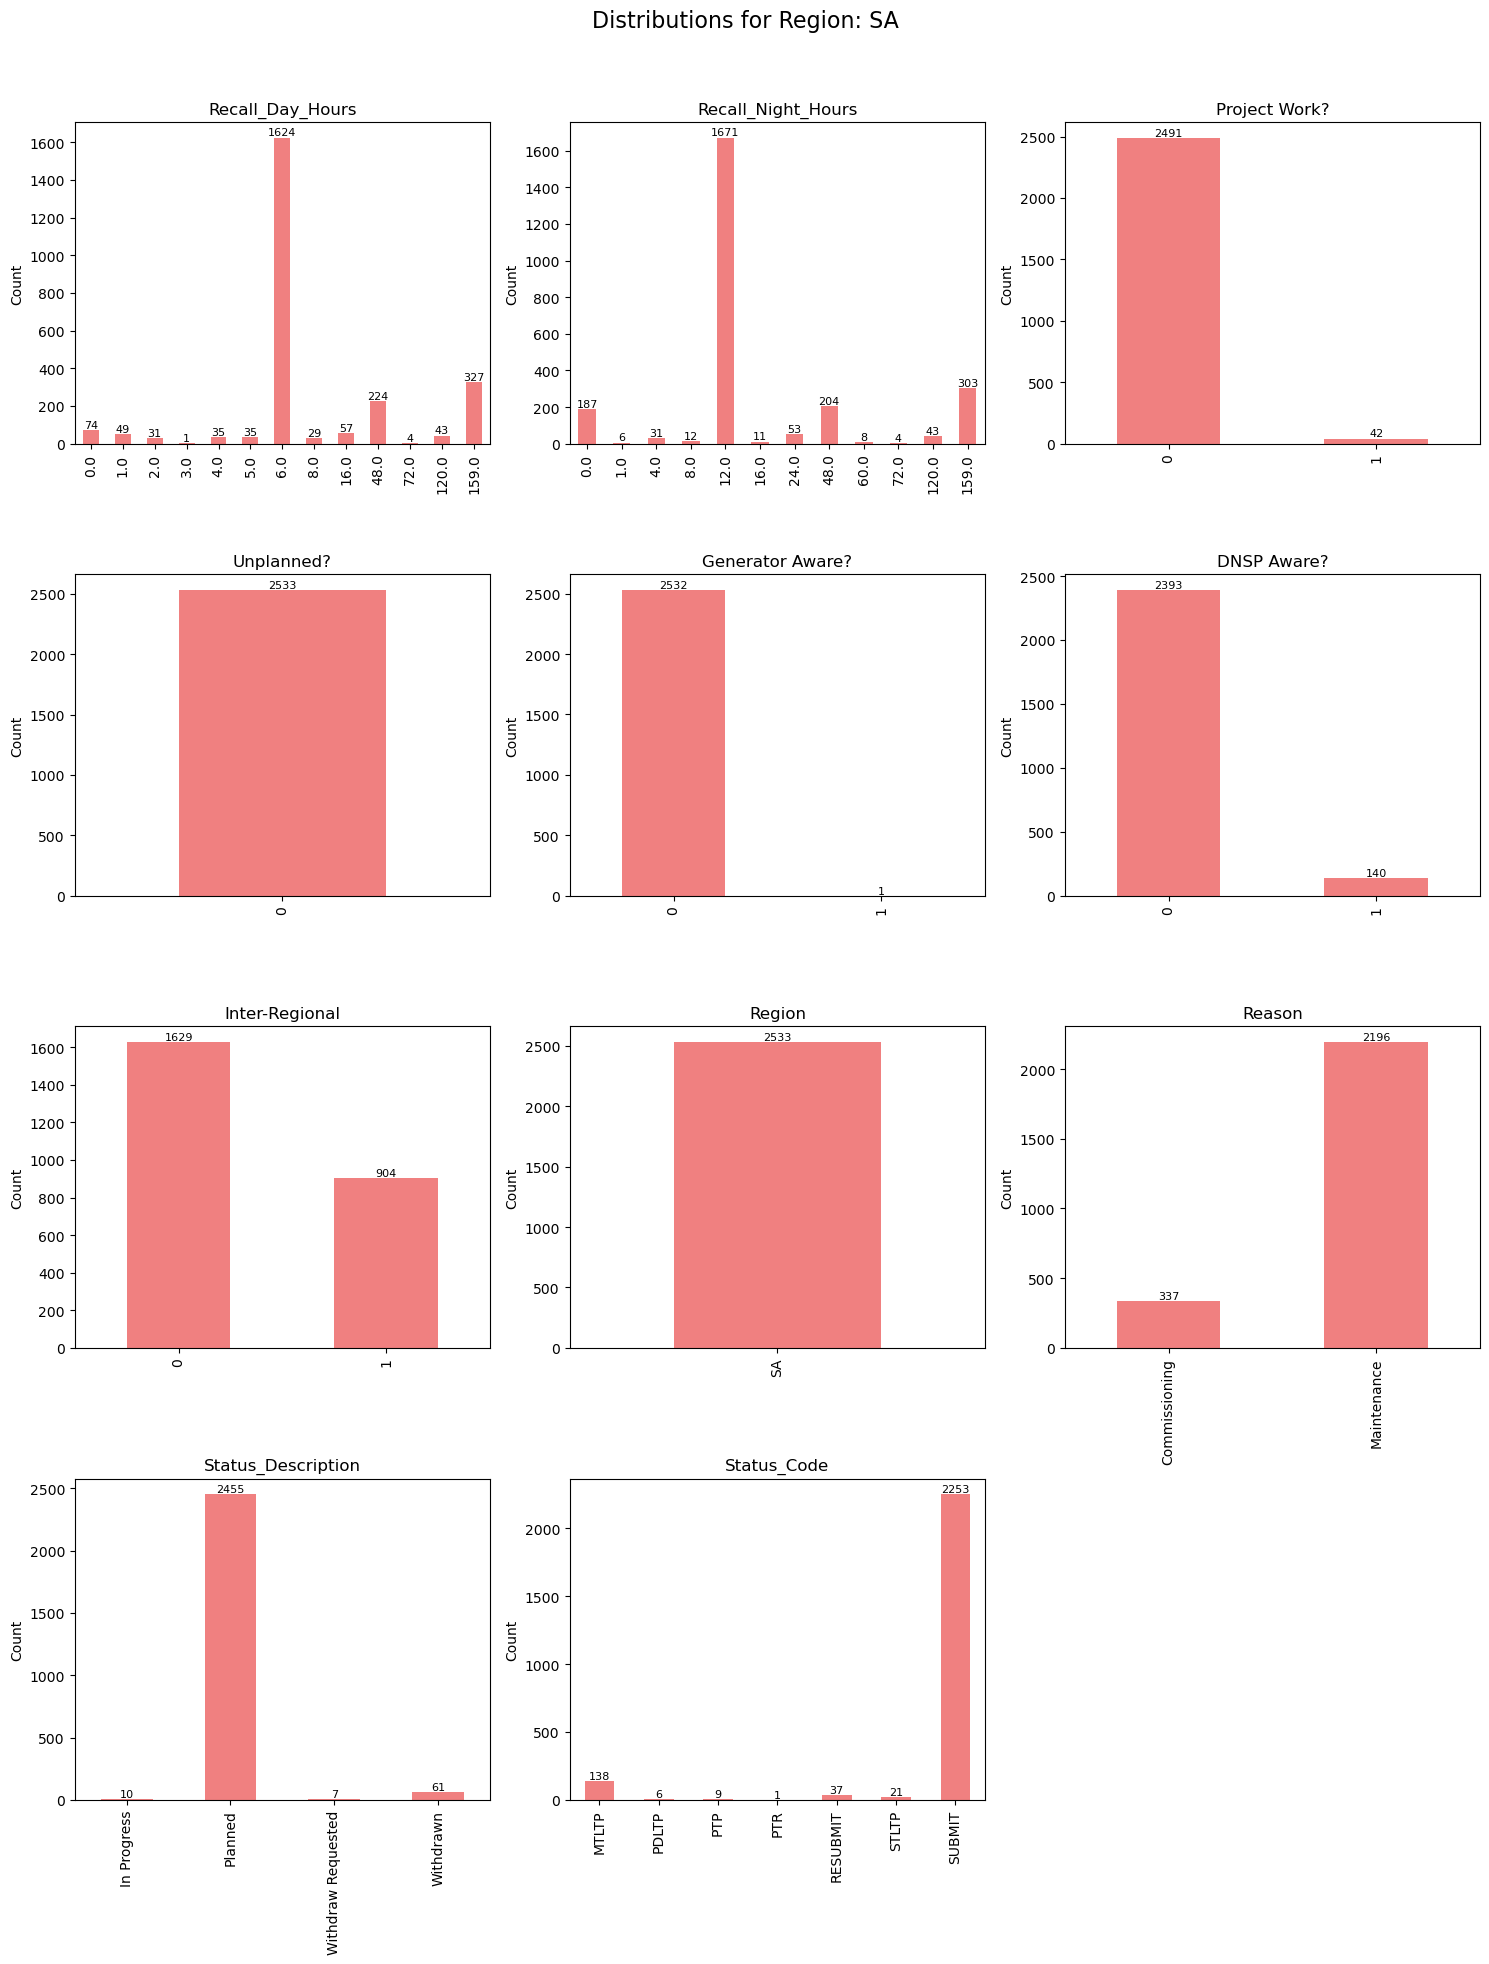

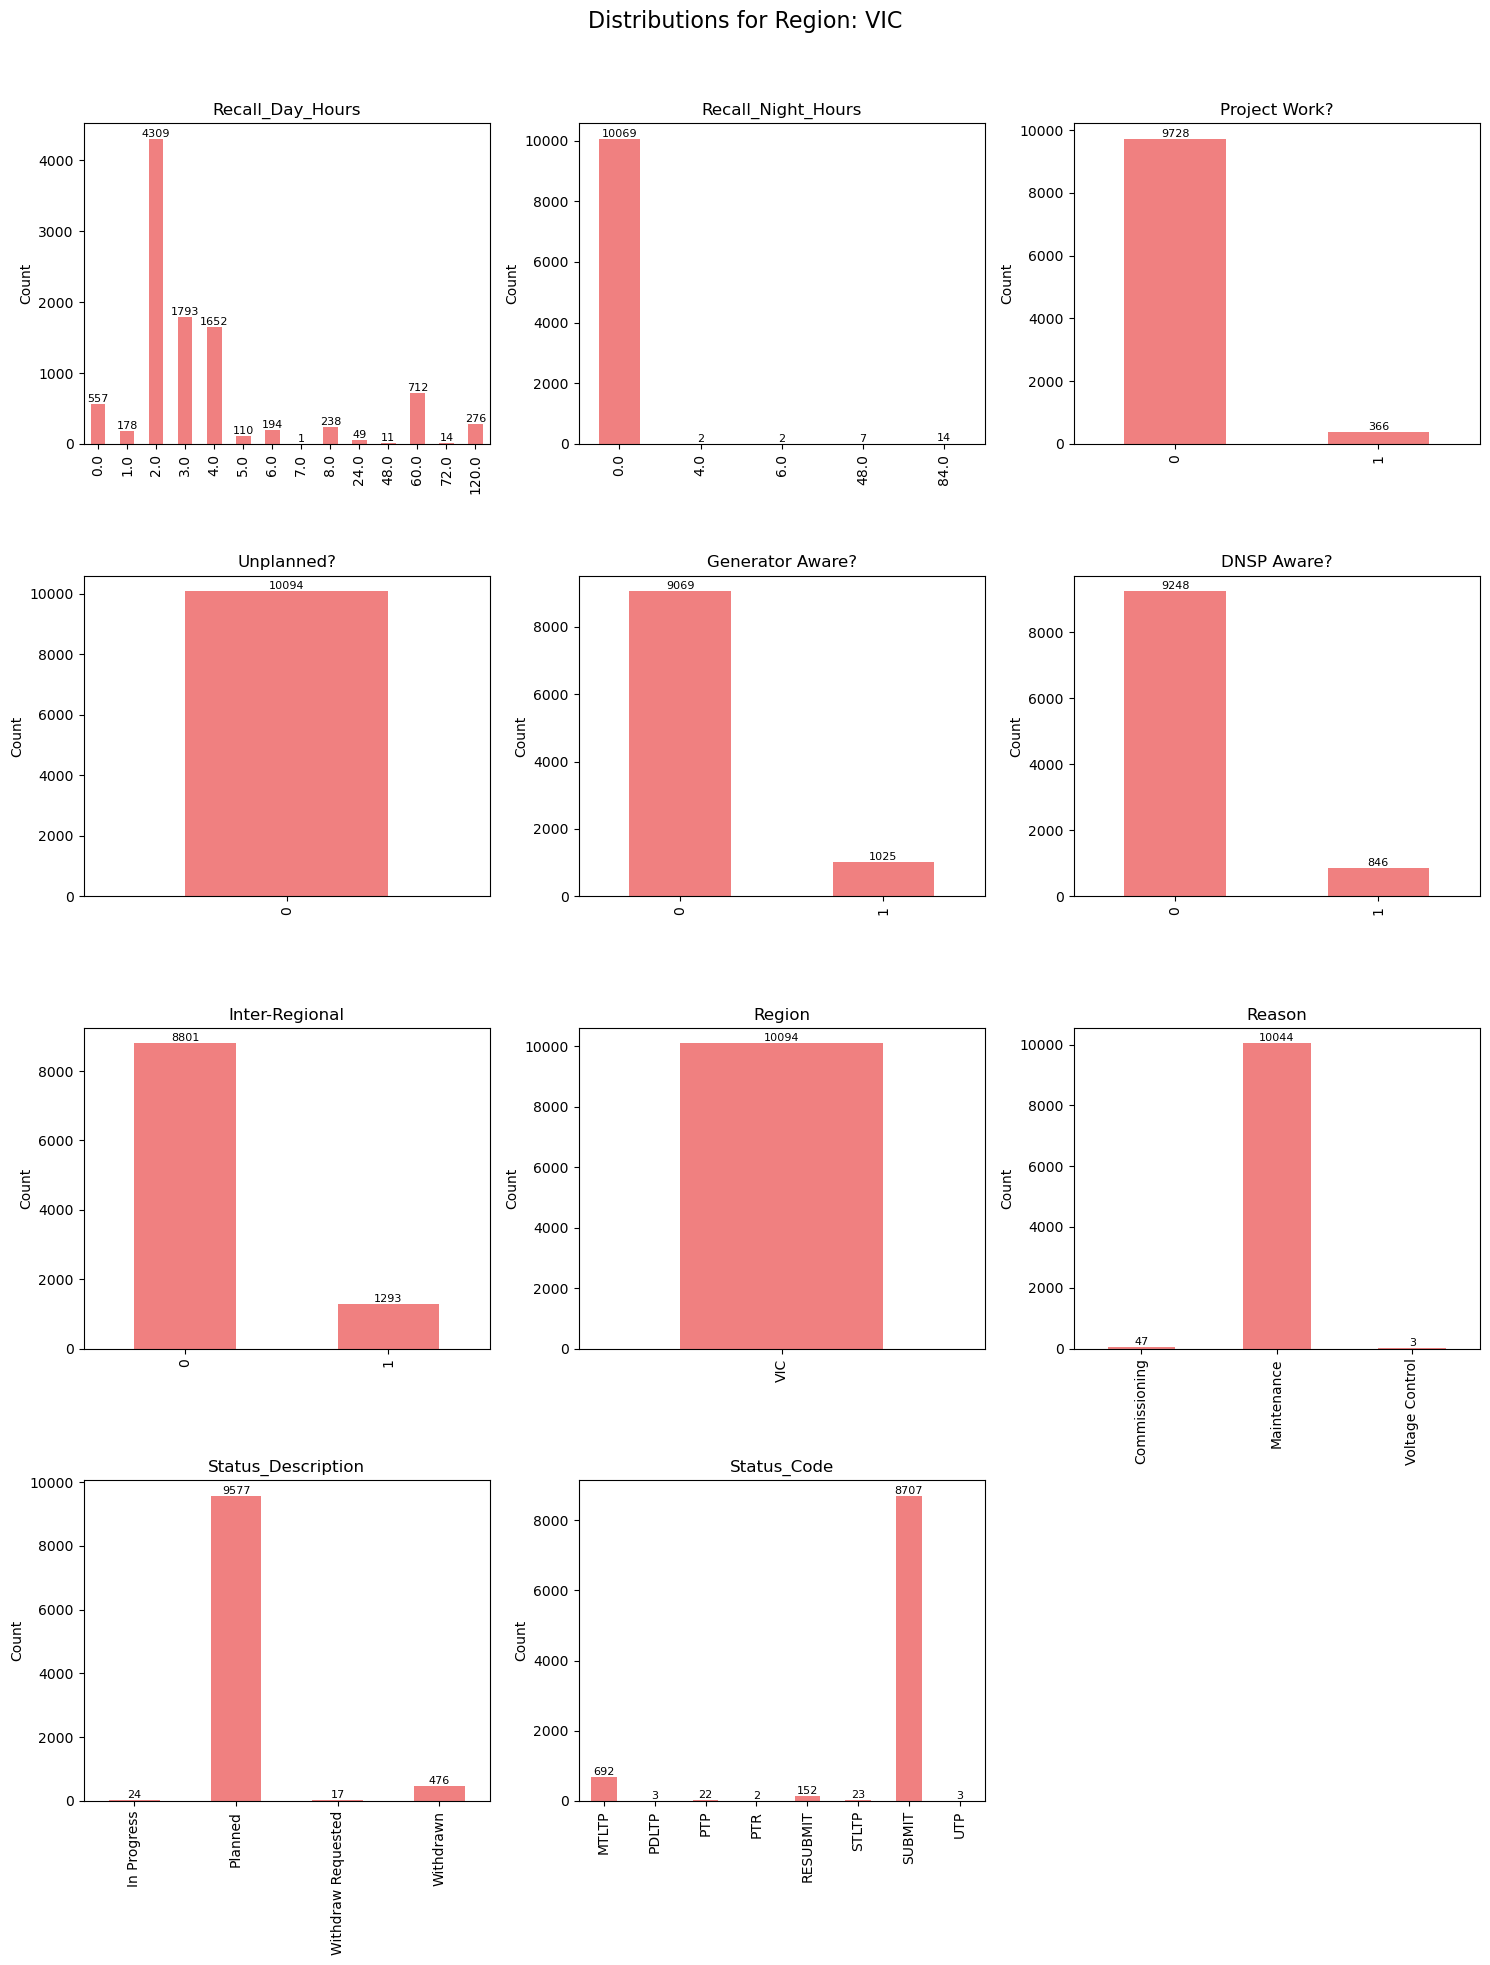

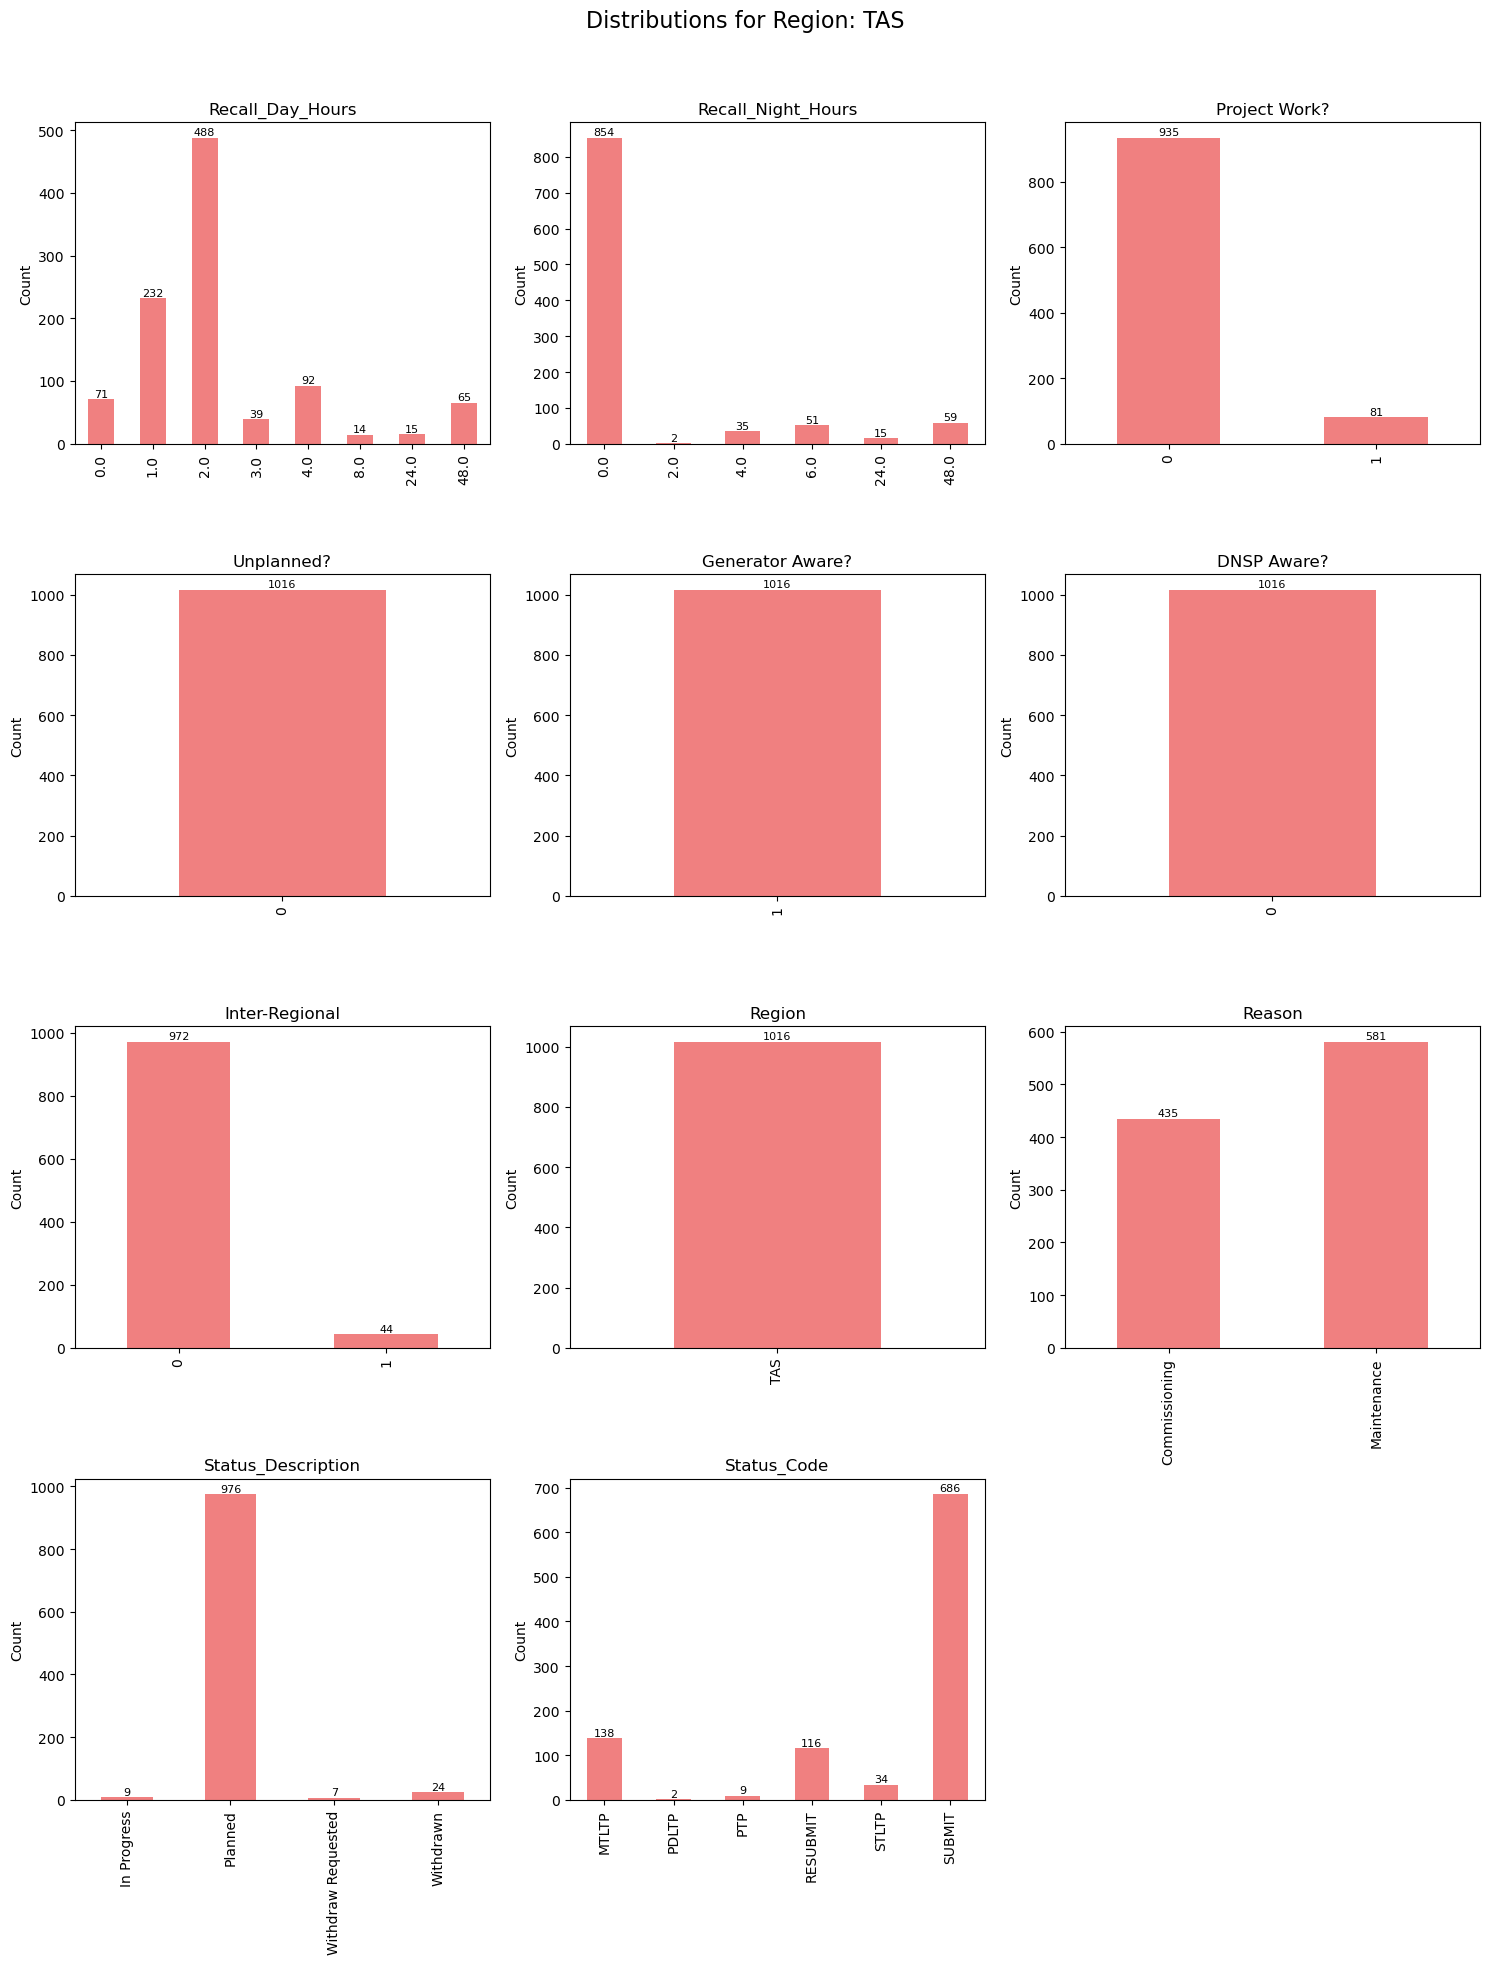

In [4]:
# visualisation for each region

regions = df['Region'].dropna().unique()
n_cols = 3

bool_cols = ['Project Work?', 'Unplanned?', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional']
numeric_cols = ['Recall_Day_Hours', 'Recall_Night_Hours']
categorical_cols = ['Region', 'Reason', 'Status_Description', 'Status_Code']

all_cols = numeric_cols + bool_cols + categorical_cols

for region in regions:
    region_df = df[df['Region'] == region]
    n_rows = (len(all_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    fig.suptitle(f'Distributions for Region: {region}', fontsize=16)

    for idx, col in enumerate(all_cols):
        ax = axes[idx]
        counts = region_df[col].value_counts().sort_index()
        counts.plot(kind='bar', ax=ax, color='lightcoral')
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Count')

        for i, value in enumerate(counts):
            ax.text(i, value + 1, str(int(value)), ha='center', va='bottom', fontsize=8)

    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Perform regression for each state

In [6]:
from regression_summary_and_plots import regression_summary_and_plots

In [7]:
# Loop through each unique region and assign a separate DataFrame
for region in df['Region'].unique():
    var_name = region.replace(" ", "_")  
    globals()[var_name] = df[df['Region'] == region].copy()


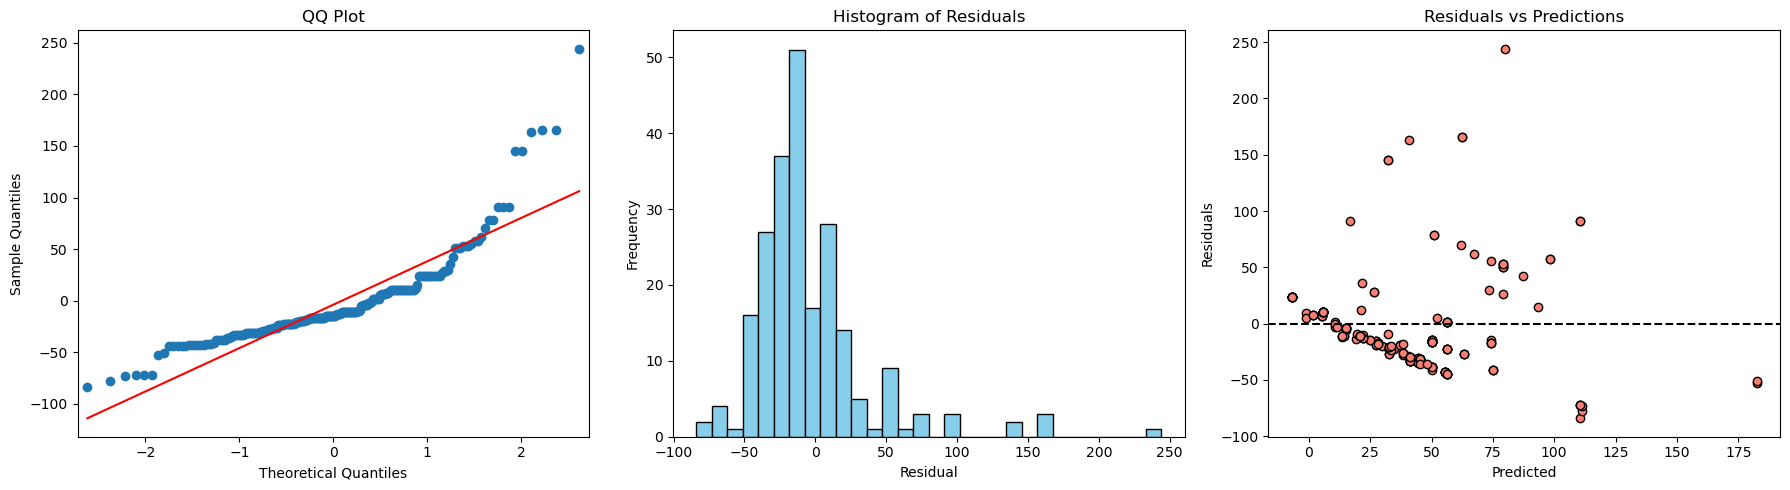

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     73.70
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           1.22e-74
Time:                        01:55:59   Log-Likelihood:                -4633.1
No. Observations:                 897   AIC:                             9280.
Df Residuals:                     890   BIC:                             9314.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.0197      1.600     26.259      0.0

In [8]:
regression_summary_and_plots(NSW, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional', 'Reason'])

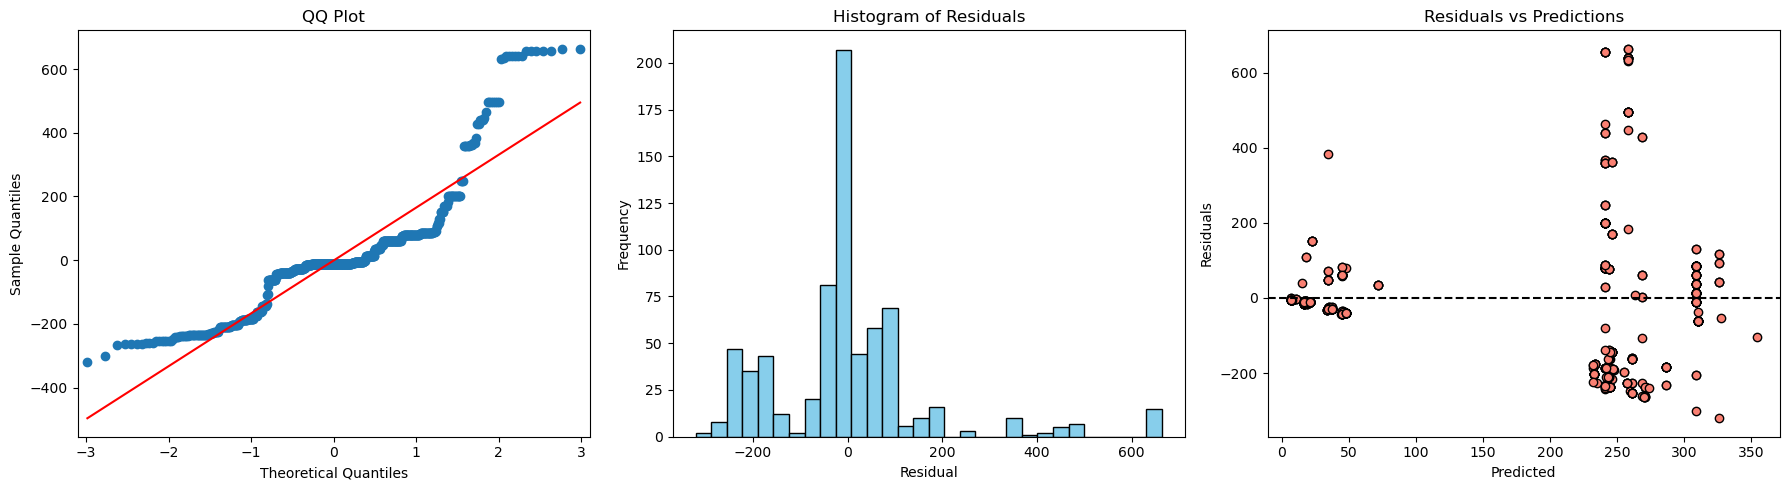

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     295.6
Date:                Thu, 24 Apr 2025   Prob (F-statistic):          1.48e-254
Time:                        01:58:00   Log-Likelihood:                -18385.
No. Observations:                2809   AIC:                         3.678e+04
Df Residuals:                    2803   BIC:                         3.682e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        260.4870      4.550     57.254      0.0

In [9]:
regression_summary_and_plots(QLD, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Generator Aware?', 'DNSP Aware?', 'Reason'])

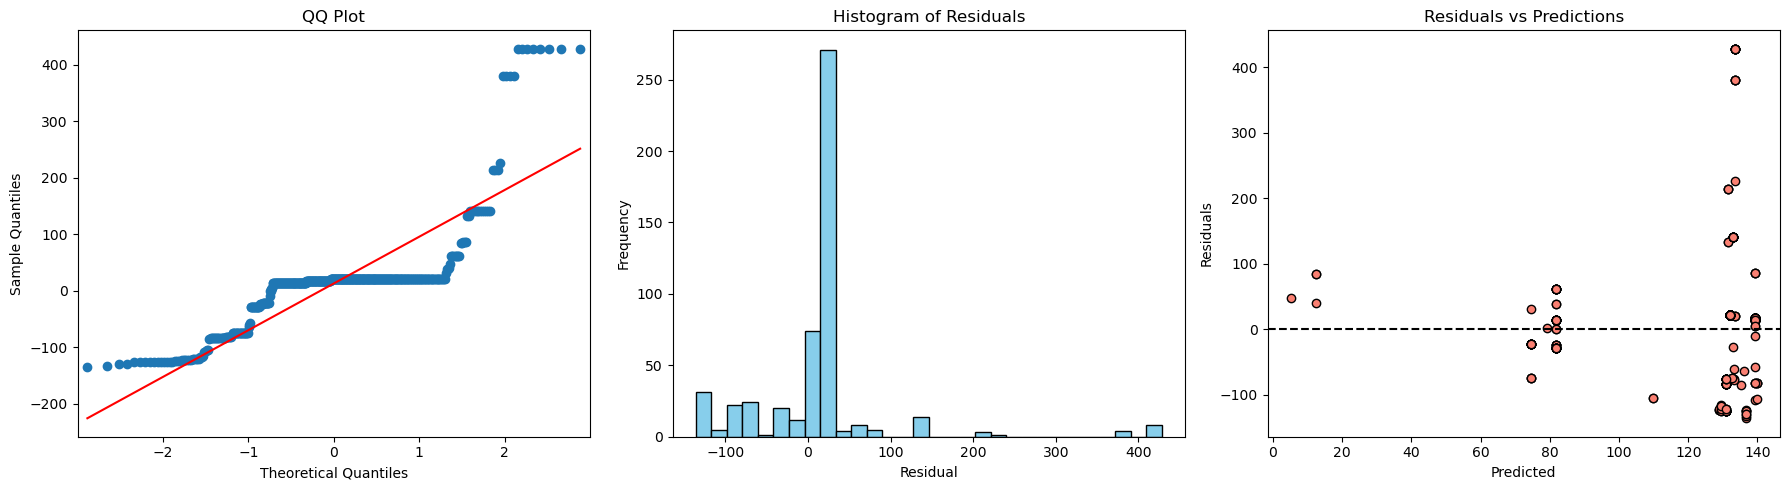

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     41.81
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           9.96e-34
Time:                        01:58:45   Log-Likelihood:                -11621.
No. Observations:                2026   AIC:                         2.325e+04
Df Residuals:                    2021   BIC:                         2.328e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.3557     11.618      6.400      0.0

In [10]:
regression_summary_and_plots(SA, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Inter-Regional', 'Reason'])

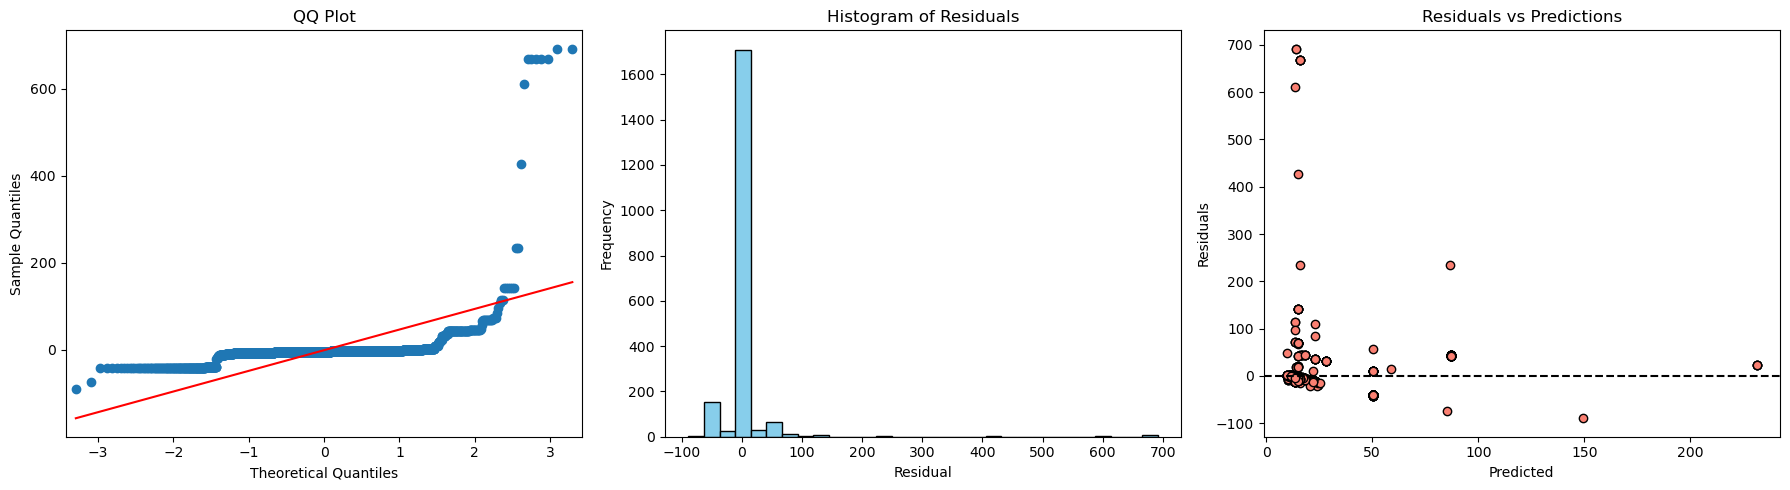

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     169.2
Date:                Thu, 24 Apr 2025   Prob (F-statistic):          2.00e-234
Time:                        02:00:13   Log-Likelihood:                -42314.
No. Observations:                8075   AIC:                         8.464e+04
Df Residuals:                    8067   BIC:                         8.470e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.1057      6.824     13.644      0.0

In [12]:
regression_summary_and_plots(VIC, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional', 'Reason'])

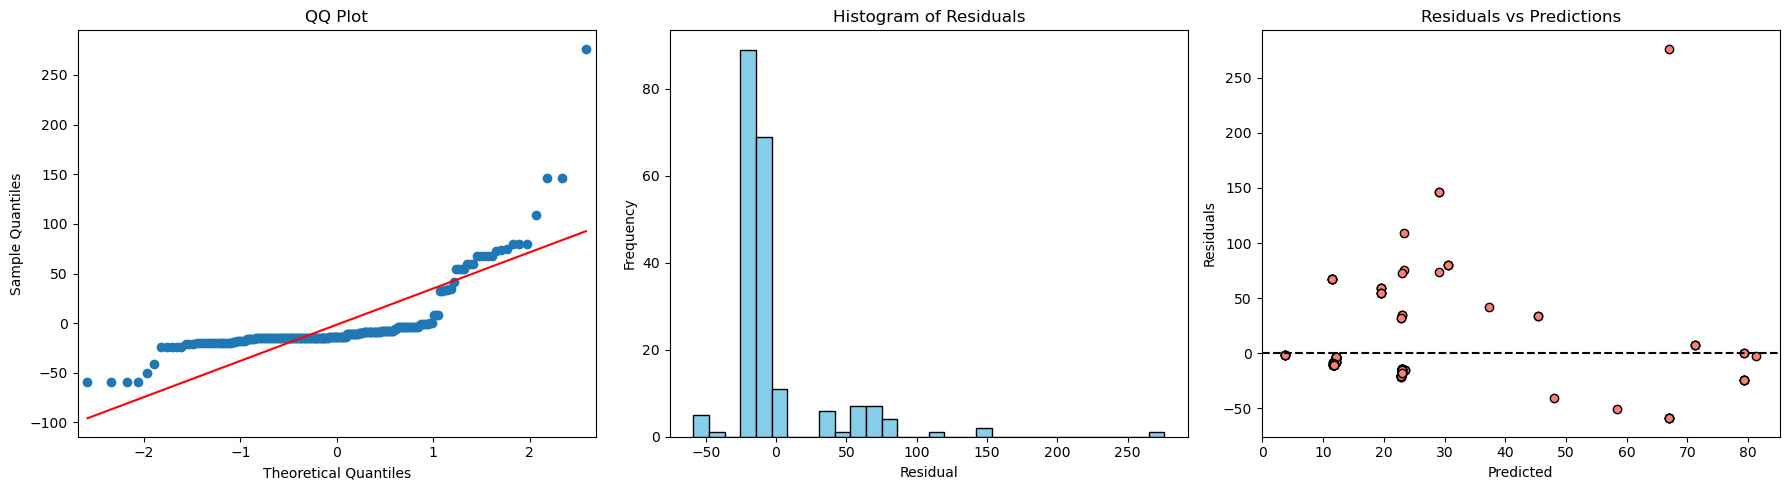

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     27.06
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           2.35e-25
Time:                        02:01:07   Log-Likelihood:                -4192.9
No. Observations:                 812   AIC:                             8398.
Df Residuals:                     806   BIC:                             8426.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2980      2.419      7.565      0.0

In [13]:
regression_summary_and_plots(TAS, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Project Work?', 'Inter-Regional', 'Reason'])